In [10]:
# Header for the notebook
from datetime import datetime
from IPython.display import display, Markdown

# Get the current date
title = "Coding Project Notebook - Circular Task"
current_date = datetime.now().strftime("%d %B %Y, %H:%M:%S")
authors = "Victor Salvat and Jin Wei Zhang (and Copilot)"

# Insert the date into the notebook
display(Markdown(f"# {title}"))
display(Markdown(f"{current_date}"))
display(Markdown(f"by {authors}"))

# Coding Project Notebook - Circular Task

28 November 2025, 18:45:54

by Victor Salvat and Jin Wei Zhang (and Copilot)

Introduction



## Table of Contents
<a id="total-title"></a>
- [1. Recreate figures and plots (visual reproduction)](#1-title)
- [2. Reproduce marker measurements (data verification)](#2-title)
- [3. Generate and analyze circular task data](#3-title)
- [4. Discussion, limitations, and conclusions](#4-title)

---
<a id="1-title"></a>
# 1. Recreate figures and plots (visual reproduction)

In [11]:
# imports 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
import matplotlib.patches as patches
from matplotlib import patches
from matplotlib.lines import Line2D


# install widget mode
%matplotlib widget

Found indices of original X≈0 split points: [ 3972  7871 11770 15655 19592]
Number of split points: 5 (should be 5)

Group 1 data: Indices [0, 3971], Data length: 3972

Group 2 data: Indices [3973, 7870], Data length: 3898

Group 3 data: Indices [7872, 11769], Data length: 3898

Group 4 data: Indices [11771, 15654], Data length: 3884

Group 5 data: Indices [15656, 19591], Data length: 3936

Successfully split into 5 valid data groups


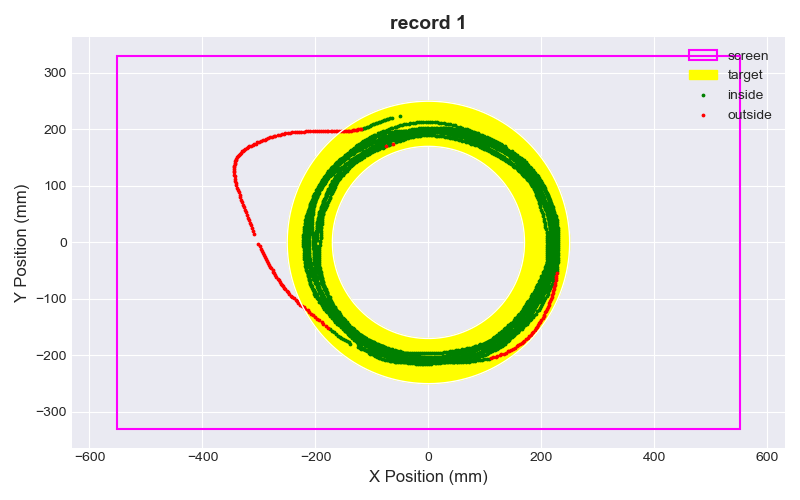

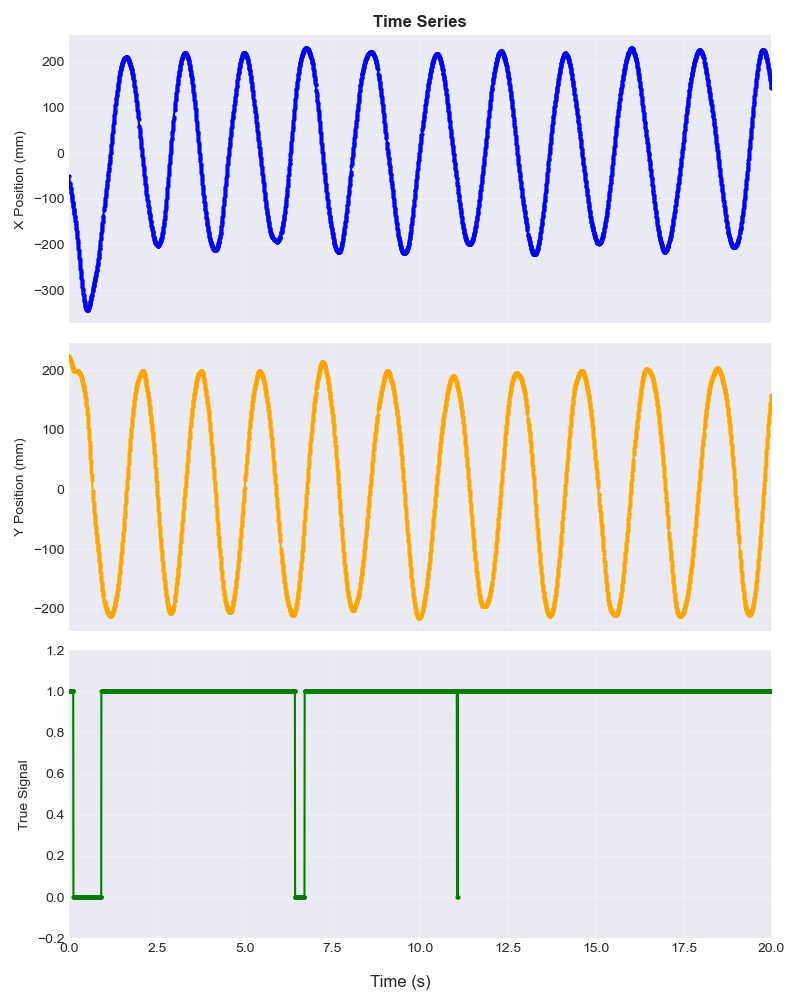

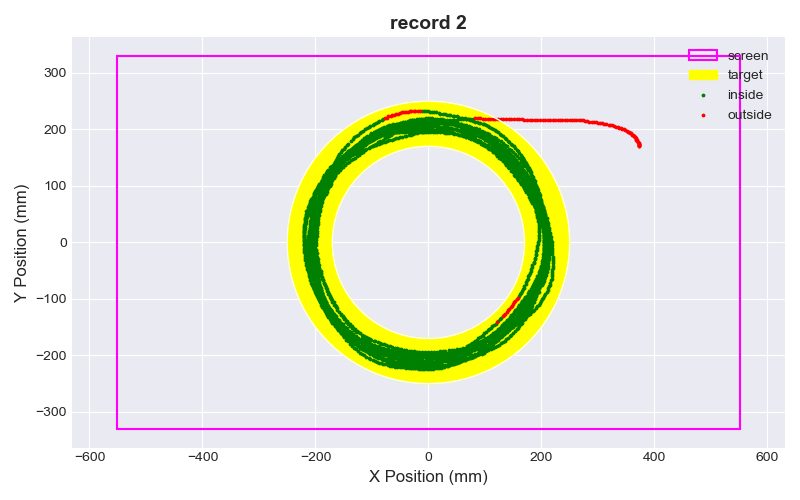

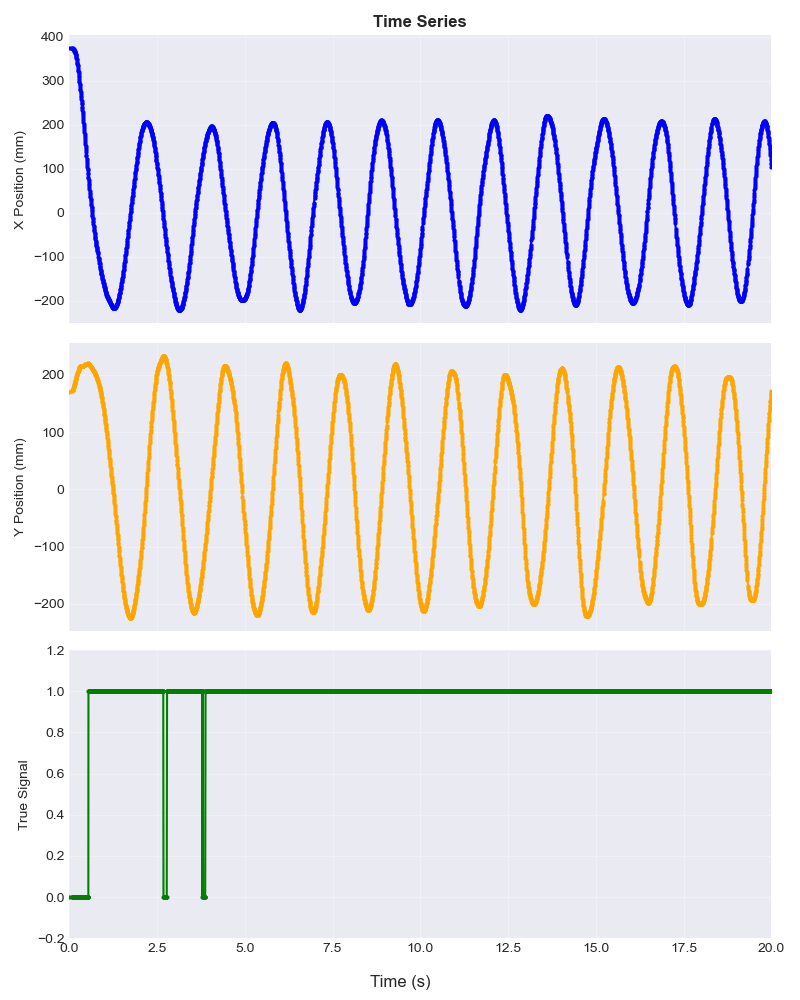

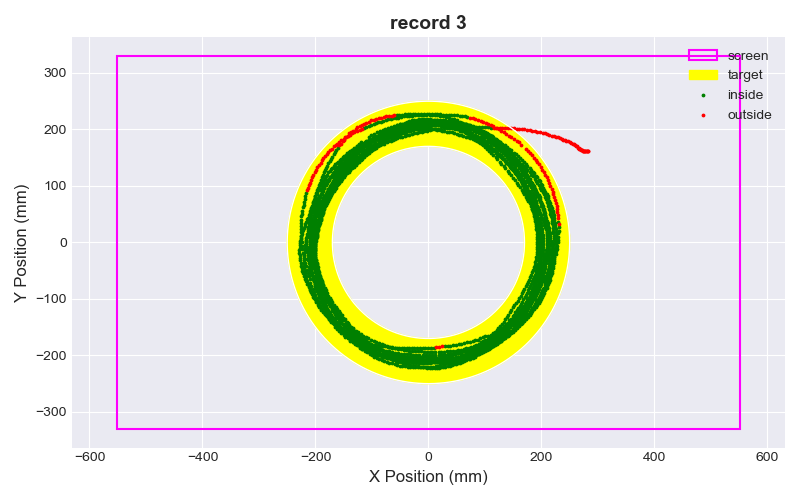

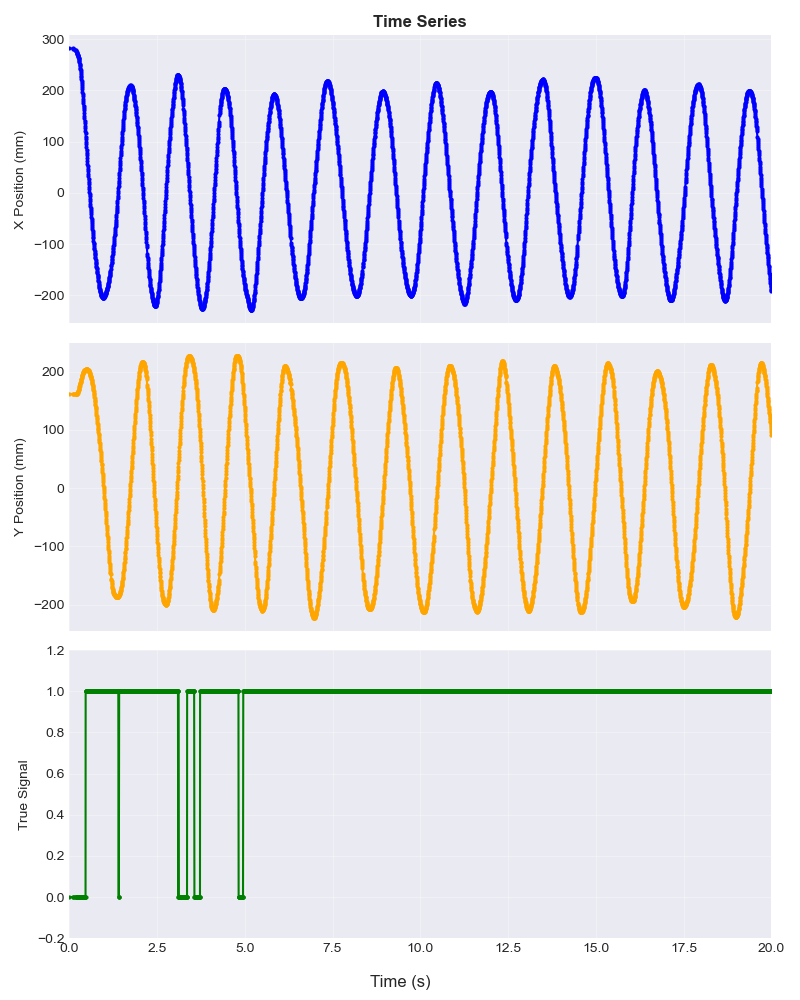

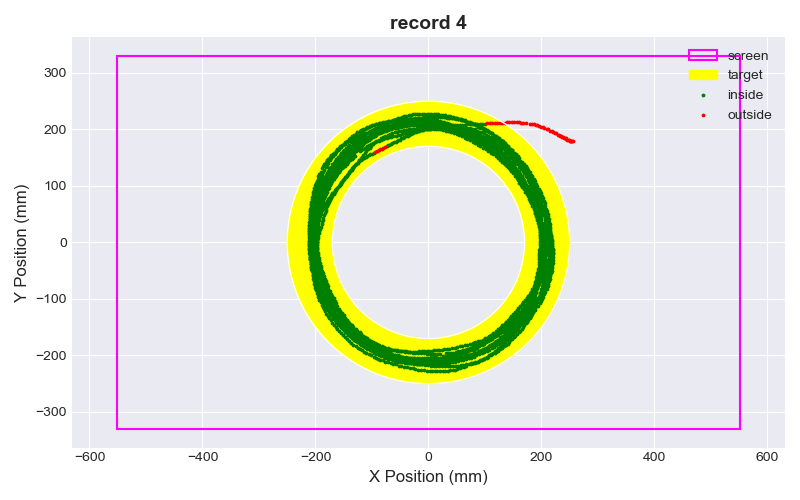

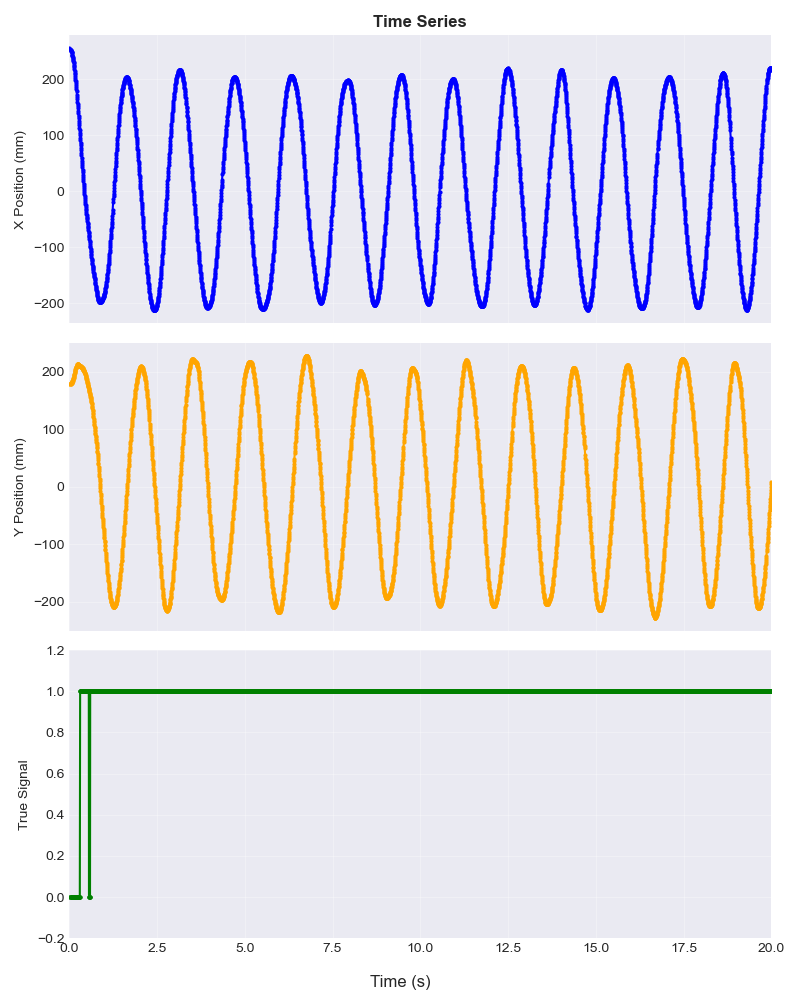

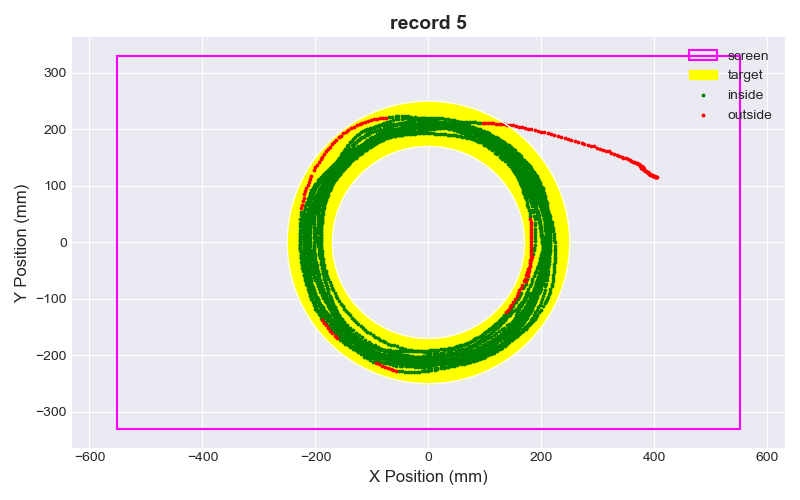

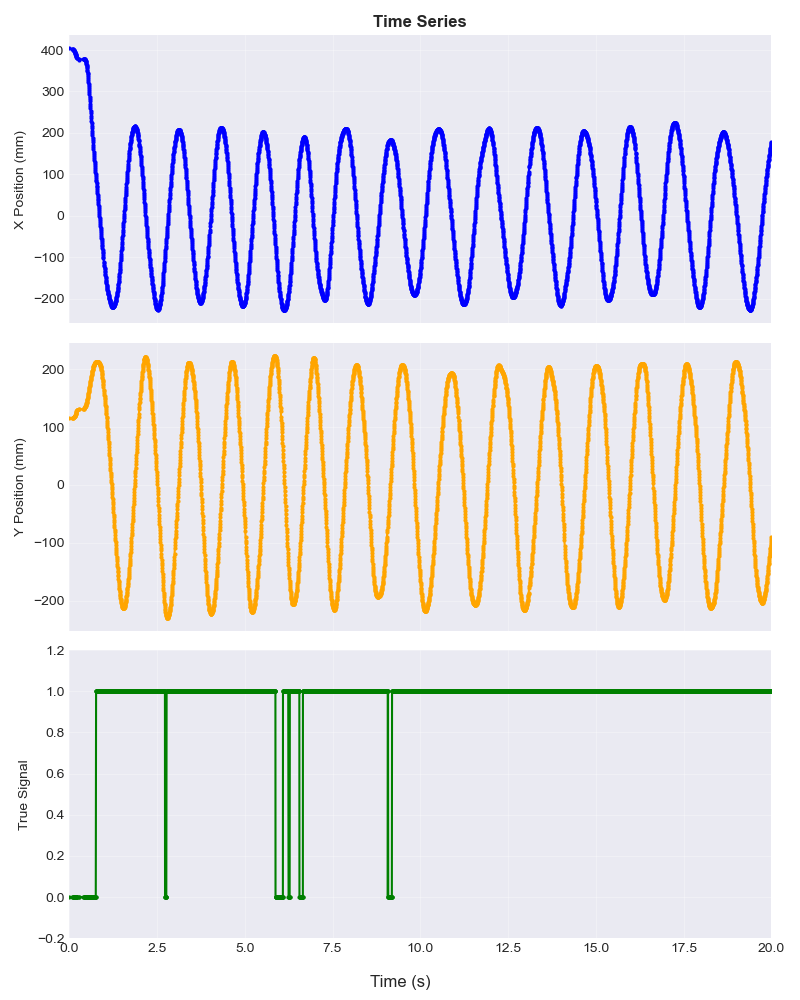

In [12]:
file_name = 'data\\001MoDe_R1.csv'
data = np.genfromtxt(file_name, delimiter=',', skip_header=4)

time_1 = data[:, 0]
x_position = data[:, 1] - 552  # X-axis: [-552,552] (origin aligned with target center)
y_position = data[:, 2] - 330  # Y-axis: [-330,330] (origin aligned with target center)
# True_signal is not used; position is determined by distance

# ----------------------
# Core: 5 original X=0 points → strictly split into 5 data groups (independent time per group)
# ----------------------
raw_x = data[:, 1]  # Original X-coordinate (without subtracting 552)
zero_x_indices = np.where(np.abs(raw_x) < 0.5)[0]
print(f"Found indices of original X≈0 split points: {zero_x_indices}")
print(f"Number of split points: {len(zero_x_indices)} (should be 5)")

if len(zero_x_indices) != 5:
    raise ValueError(f"Expected 5 original X=0 split points, but found {len(zero_x_indices)}. Please check the data!")

# Loop to split into 5 data groups (strictly according to requirements)
data_groups = []
for i in range(5):
    if i == 0:
        # Group 1: Index 1 → before first split point (excludes split point)
        start_idx = 0
        end_idx = zero_x_indices[0] - 1
    else:
        # Groups 2-5: After previous split point → before current split point (excludes both split points)
        start_idx = zero_x_indices[i-1] + 1
        end_idx = zero_x_indices[i] - 1
    
    # Ensure valid indices (start_idx < end_idx)
    if start_idx >= end_idx:
        print(f"Warning: Invalid indices for Group {i+1} ([{start_idx}, {end_idx}]), skipping this group!")
        continue
    
    # Extract all data for current group (X/Y/time/True Signal, only valid for current group)
    group = {
        'group_num': i+1,
        'start_idx': start_idx,
        'end_idx': end_idx,
        'x': x_position[start_idx:end_idx+1],  # Slice is right-exclusive, need +1
        'y': y_position[start_idx:end_idx+1],
        'time': time_1[start_idx:end_idx+1],   # Independent time per group, only current group range
        'true_signal': data[:, 3][start_idx:end_idx+1]
    }
    data_groups.append(group)
    print(f"\nGroup {i+1} data: Indices [{start_idx}, {end_idx}], Data length: {len(group['x'])}")

print(f"\nSuccessfully split into {len(data_groups)} valid data groups")

# ----------------------
# Loop to plot each group (2 plots per group: separate trajectory plot + 3 independent time subplots)
# ----------------------
externalRadius = 250.0
internalRadius = 170.0
screen_x = [-552, 552, 552, -552, -552]
screen_y = [-330, -330, 330, 330, -330]
theta = np.linspace(0, 2*np.pi, 1000)
outer_circle_x = externalRadius * np.cos(theta)
outer_circle_y = externalRadius * np.sin(theta)
inner_circle_x = internalRadius * np.cos(theta)
inner_circle_y = internalRadius * np.sin(theta)

for group in data_groups:
    group_num = group['group_num']
    x = group['x']
    y = group['y']
    time = group['time']  # Time only for current group, changes with each loop
    true_signal = group['true_signal']
    
    # ----------------------
    # Plot 1: Separate trajectory plot for the group (original logic unchanged)
    # ----------------------
    plt.figure(figsize=(8, 5))
    
    # 1. Bottom layer: Screen
    screen = patches.Polygon(list(zip(screen_x, screen_y)), closed=True, linewidth=1.5, edgecolor="magenta", facecolor="none", label="screen")
    plt.gca().add_patch(screen)
    
    
    # 2. Middle layer: Yellow annular background
    ring = Wedge(
        center=(0, 0),
        r=externalRadius,
        theta1=0, theta2=360,
        width=externalRadius - internalRadius,
        color="#FFFF00",
        alpha=1.0,
        label='target'
    )
    plt.gca().add_patch(ring)
    
    # 3. Top layer: Target borders
    plt.plot(outer_circle_x, outer_circle_y, color='white', linewidth=1.0)
    plt.plot(inner_circle_x, inner_circle_y, color='white', linewidth=1.0)
    
    # 4. Color-coded trajectory (ring-swapped logic)
    # distances = np.sqrt(x**2 + y**2)
    # x_red = x[(distances >= internalRadius) & (distances <= externalRadius)]  # Outside → red
    # y_red = y[(distances >= internalRadius) & (distances <= externalRadius)]
    # x_green = x[(distances < internalRadius) | (distances > externalRadius)]  # Inside → green
    # y_green = y[(distances < internalRadius) | (distances > externalRadius)]
    
    threshold = 0.5  # Since true_signal is binary (0 or 1)
    x_green = x[true_signal >= threshold]  # true_signal=1 → green (original "outside" label)
    y_green = y[true_signal >= threshold]
    x_red = x[true_signal < threshold]    # true_signal=0 → red (original "inside" label)
    y_red = y[true_signal < threshold]

    plt.scatter(x_green, y_green, s=3, color='green', label='inside')
    plt.scatter(x_red, y_red, s=3, color='red', label='outside')
    
    # Style adjustments
    plt.title(f'record {group_num}', fontweight='bold', fontsize=14)
    plt.xlabel('X Position (mm)', fontsize=12)
    plt.ylabel('Y Position (mm)', fontsize=12)
    plt.xlim([-552, 552])
    plt.ylim([-330, 330])
    #plt.grid(True, alpha=0.3)
    plt.legend(loc='upper right', fontsize=10)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    # ----------------------
    # Plot 2: 3 time series subplots for the group (time only for current group, normalized to 0~20s)
    # ----------------------
    
    # ----------------------
    # Plot 2: 3 time series subplots for the group (time only for current group, normalized to 0~20s)
    # ----------------------
    fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

    # Normalize time to 0~20 seconds (only using current group's time, recalculated each loop)
    time_min, time_max = time.min(), time.max()
    if time_max - time_min < 1e-6:
        time_mapped = np.zeros_like(time)
    else:
        time_mapped = (time - time_min) / (time_max - time_min) * 20
        
    # Subplot 1: Time vs X Position (current group time)
    axs[0].plot(time_mapped, x, marker='o', markersize=2, color='blue')
    axs[0].set_ylabel("X Position (mm)")
    axs[0].set_title(f"Time Series", fontweight="bold")
    axs[0].grid(alpha=0.3)
    axs[0].set_xlim([0, 20])
    
    # Subplot 2: Time vs Y Position (current group time)
    axs[1].plot(time_mapped, y, marker='o', markersize=2, color='orange')
    axs[1].set_ylabel("Y Position (mm)")
    axs[1].grid(alpha=0.3)

    # Subplot 3: Time vs Original True Signal (current group time)
    axs[2].plot(time_mapped, true_signal, marker='o', markersize=2, color='green')
    axs[2].set_ylabel("True Signal")
    axs[2].grid(alpha=0.3)
    axs[2].set_ylim([-0.2, 1.2])
    # Single global X label
    fig.supxlabel("Time (s)")

    plt.tight_layout()
    plt.show()

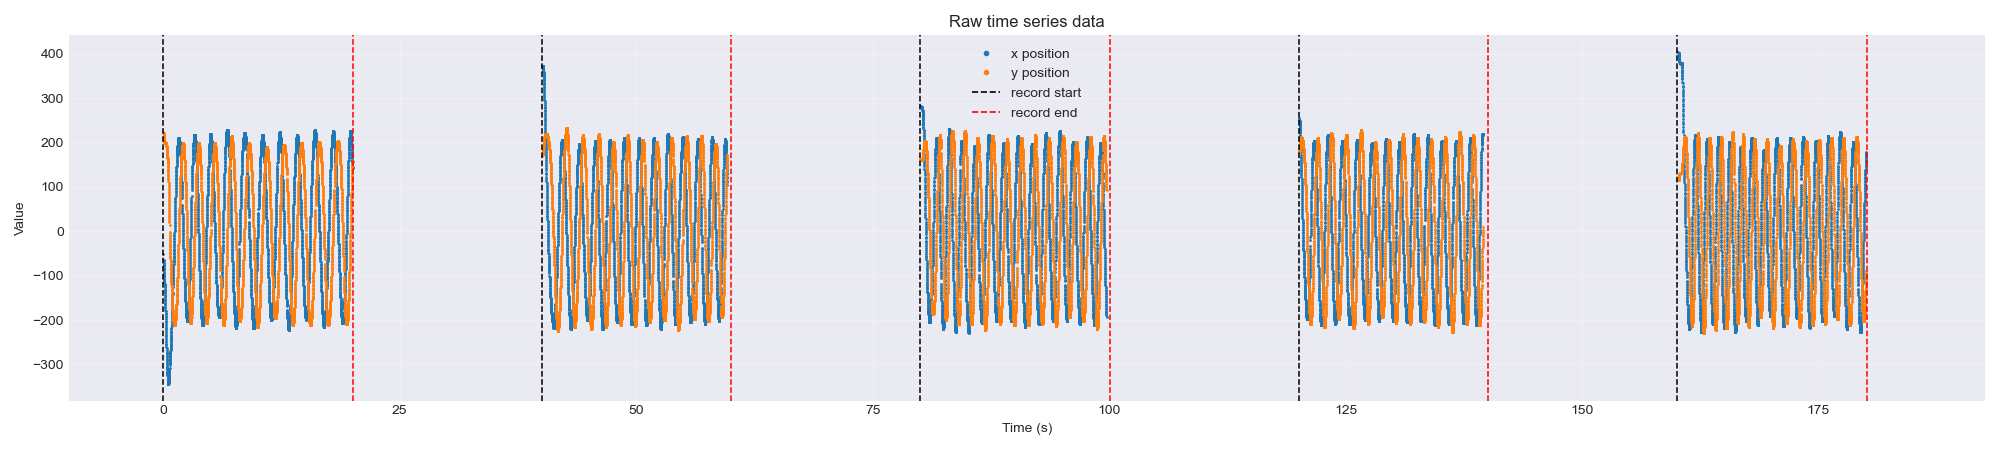

In [13]:
# -----------------------------------------------------
# Combined raw time-series plot for all 5 data groups
# -----------------------------------------------------
rec_start = np.array([0.004, 40.011, 80.043, 120.061, 160.090])    # record times
rec_end   = np.array([20.007, 60.022, 100.057, 140.075, 180.104])  # record times

plt.figure(figsize=(20, 4.5))

# Plot each group at the correct global time (seconds)
for i, group in enumerate(data_groups):
    t = group['time']
    x = group['x']
    y = group['y']

    # Convert group-local time to seconds starting at 0.0 s
    t_seconds = (t - t.min()) / 1000.0

    # Shift to the known record start time (seconds)
    t_global = t_seconds + rec_start[i]

    # Plot with fixed colors
    plt.plot(t_global, x, '.', ms=2, color='tab:blue', label='x position' if i == 0 else None)
    plt.plot(t_global, y, '.', ms=2, color='tab:orange', label='y position' if i == 0 else None)

# Plot vertical lines for start and end of each record
for j in range(len(rec_start)):
    plt.axvline(rec_start[j], color='black', linestyle='--', linewidth=1.1,
                label='record start' if j == 0 else None)
    plt.axvline(rec_end[j],   color='red',   linestyle='--', linewidth=1.1,
                label='record end' if j == 0 else None)
    
# Create custom legend elements
legend_elements = [
    Line2D([], [], color='tab:blue',   marker='.', linestyle='None', markersize=6, label='x position'),
    Line2D([], [], color='tab:orange', marker='.', linestyle='None', markersize=6, label='y position'),
    Line2D([], [], color='black', linestyle='--', linewidth=1.2, label='record start'),
    Line2D([], [], color='red',   linestyle='--', linewidth=1.2, label='record end')
]

# Final plot adjustments
plt.xlim(rec_start[0] - 10.0, rec_end[-1] + 12.5)
plt.xlabel("Time (s)")
plt.ylabel("Value")
plt.title("Raw time series data")
plt.grid(alpha=0.25)
plt.legend(handles=legend_elements, loc='upper center', ncol=1, frameon=False)
plt.tight_layout()
plt.show()

<a id="2-title"></a>
# 2. [Reproduce marker measurements (data verification)](#total-title)

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------
# Load data
# ----------------------
file_name = 'data\\001MoDe_R1.csv'
data = np.genfromtxt(file_name, delimiter=',', skip_header=4)

time_ms = data[:, 0]
x_position = data[:, 1] - 552  # centered
y_position = data[:, 2] - 330  # centered
true_signal_all = data[:, 3]
raw_x = data[:, 1]

# ----------------------
# Split into record groups using X ≈ 0 markers
# ----------------------
zero_x_indices = np.where(np.abs(raw_x) < 0.5)[0]
data_groups = []

for i in range(5):
    if i == 0:
        start_idx = 0
        end_idx = zero_x_indices[0] - 1 if len(zero_x_indices) > 0 else len(raw_x) - 1
    else:
        start_idx = zero_x_indices[i-1] + 1
        end_idx = zero_x_indices[i] - 1 if i < len(zero_x_indices) else len(raw_x) - 1
    
    if start_idx >= end_idx or start_idx >= len(raw_x):
        continue
    
    group = {
        'group_num': i+1,
        'start_idx': start_idx,
        'end_idx': end_idx,
        'x': x_position[start_idx:end_idx+1],
        'y': y_position[start_idx:end_idx+1],
        'time': time_ms[start_idx:end_idx+1],
        'true_signal': true_signal_all[start_idx:end_idx+1]
    }
    data_groups.append(group)

# ----------------------
# Constants from configuration
# ----------------------
R_theory = 209.5   # px (theoretical radius)
T_theory = 47.0    # px (theoretical tolerance)

# Task limits (adjust these based on your configuration)
EXTERNAL_LIMIT = 250  # outer radius in pixels
INTERNAL_LIMIT = 170  # inner radius in pixels

def compute_metrics(g):
    """
    Compute performance metrics matching the Java implementation.
    """
    x, y = g['x'], g['y']
    t_ms = g['time']  # Keep in milliseconds initially
    sig = g['true_signal']
    
    # Compute radius from center
    r = np.sqrt(x**2 + y**2)
    
    # Compute angles (Note: negate y to match Java coordinate system)
    # Java uses screen coordinates where Y increases downward
    angles = np.arctan2(-y, x)  # Negative y for screen coordinates
    
    # ---- Find first entry into target (annulus) ----
    inside_mask = (r >= INTERNAL_LIMIT) & (r <= EXTERNAL_LIMIT)
    inside_idx = np.where(inside_mask)[0]
    
    if len(inside_idx) == 0:
        return None
    
    i0 = inside_idx[0]  # First time inside target
    first_time_in = t_ms[i0]
    
    # Trim arrays to valid interval (from first entry onward)
    r = r[i0:]
    angles = angles[i0:]
    t_ms = t_ms[i0:]
    sig = sig[i0:]
    x = x[i0:]
    y = y[i0:]
    
    # ---- Compute angular distance (matching Java phaseAngle logic) ----
    # Calculate angular differences, handling wraparound
    angle_diffs = np.diff(angles)
    
    # Unwrap angles: correct jumps around ±π (matching Java logic exactly)
    angle_diffs = np.where(angle_diffs > np.pi, angle_diffs - 2*np.pi, angle_diffs)
    angle_diffs = np.where(angle_diffs < -np.pi, angle_diffs + 2*np.pi, angle_diffs)
    
    # Total angular distance (sum of all incremental angles with sign)
    total_angle = np.sum(angle_diffs)
    
    # ---- nLaps ----
    # Java: angleTotalTable[i] / (2*Math.PI)
    # Note: Sign indicates direction (negative = counter-clockwise)
    nLaps = total_angle / (2 * np.pi)
    
    if abs(nLaps) < 0.01:  # Avoid division by zero
        return None
    
    # ---- Movement Time ----
    # Java: MTe = (time - fistTimeIn) / 1000 (converts ms to seconds)
    total_time_ms = t_ms[-1] - t_ms[0]
    total_time_s = total_time_ms / 1000.0
    MT_per_lap = total_time_s / abs(nLaps)
    
    # ---- Re (effective radius) ----
    # Java: radiusMean (simple mean of all radii)
    Re = np.mean(r)
    
    # ---- Te (effective tolerance) ----
    # Java: effectiveTolerance = Math.sqrt(2 * Math.PI * Math.E) * radiusStd
    # This is approximately 4.133 * std
    radiusStd = np.std(r, ddof=1)  # Sample std (n-1)
    Te = np.sqrt(2 * np.pi * np.e) * radiusStd
    
    # ---- Error percentage ----
    # Java: 100 * errAngle / totAngle
    # Uses the true_signal column to determine if inside/outside target
    # true_signal appears to be 1.0 when inside, 0.0 when outside
    inside_target = sig >= 0.5  # Threshold at 0.5
    outside_mask = ~inside_target[:-1]  # Exclude last point for diff alignment
    
    # Sum absolute angular distances when outside target
    angle_outside = np.sum(np.abs(angle_diffs[outside_mask]))
    
    # Calculate error as percentage of total angular distance
    error = 100.0 * angle_outside / abs(total_angle) if abs(total_angle) > 0 else 0
    
    # ---- IDe (Index of Difficulty Effective) ----
    # Java: effectiveDistance = Math.abs(effectiveAngle * effectiveRadius)
    #       IDe = effectiveDistance / effectiveTolerance
    effective_distance = abs(total_angle * Re)
    IDe_total = effective_distance / Te if Te > 0 else 0
    IDe_per_lap = IDe_total / abs(nLaps)
    
    # ---- Be (Bias) ----
    # Java: bias = effectiveTolerance / configuration.getCircularTask().tolerance_px
    Be = Te / T_theory
    
    # ---- IPe (Information Processing Rate) ----
    # Java: IPeTable[currentTrial] = IDe / MTeTable[currentTrial]
    IPe = IDe_total / total_time_s if total_time_s > 0 else 0
    
    return {
        'nLaps': nLaps,
        'Re': Re,
        'Te': Te,
        'error': error,
        'MT/lap': MT_per_lap,
        'IDe/lap': IDe_per_lap,
        'Be': Be,
        'IPe': IPe,
        'total_time': total_time_s,
        'IDe_total': IDe_total
    }

# ----------------------
# Compute and print results table
# ----------------------
print("    Var , nLaps ,      Re ,      Te ,   error ,  MT/lap , IDe/lap ,      Be ,     IPe ,")
print("   unit ,   lap ,   pixel ,   pixel ,       % ,   s/lap , bit/lap ,  double ,   bit/s ,")
print(f" Theory ,  1.00 , {R_theory:8.2f} , {T_theory:8.2f} ,    3.88 ,         ,         ,    1.00 ,         ,")

results = []
for i, g in enumerate(data_groups):
    m = compute_metrics(g)
    if m is None:
        print(f" Rec{i+1:03d} ,  0.00 ,    0.00 ,    0.00 ,     NaN ,     NaN ,     NaN ,    0.00 ,    0.00 ,")
        continue
    
    results.append(m)
    
    print(
        f" Rec{i+1:03d} ,"
        f"{m['nLaps']:6.2f} ,"
        f"{m['Re']:8.2f} ,"
        f"{m['Te']:8.2f} ,"
        f"{m['error']:8.2f} ,"
        f"{m['MT/lap']:8.2f} ,"
        f"{m['IDe/lap']:8.2f} ,"
        f"{m['Be']:8.2f} ,"
        f"{m['IPe']:8.2f} ,"
    )

    Var , nLaps ,      Re ,      Te ,   error ,  MT/lap , IDe/lap ,      Be ,     IPe ,
   unit ,   lap ,   pixel ,   pixel ,       % ,   s/lap , bit/lap ,  double ,   bit/s ,
 Theory ,  1.00 ,   209.50 ,    47.00 ,    3.88 ,         ,         ,    1.00 ,         ,
 Rec001 ,-10.85 ,  213.87 ,   91.79 ,    3.89 ,    1.84 ,   14.64 ,    1.95 ,    7.94 ,
 Rec002 ,-11.99 ,  209.92 ,   35.00 ,    0.94 ,    1.59 ,   37.68 ,    0.74 ,   23.66 ,
 Rec003 ,-13.28 ,  209.49 ,   42.77 ,    2.96 ,    1.45 ,   30.78 ,    0.91 ,   21.23 ,
 Rec004 ,-12.84 ,  209.52 ,   37.56 ,    0.27 ,    1.49 ,   35.05 ,    0.80 ,   23.45 ,
 Rec005 ,-14.77 ,  210.96 ,   44.24 ,    3.00 ,    1.30 ,   29.96 ,    0.94 ,   23.00 ,


<a id="3-title"></a>
# 3. [Generate and analyze circular task data](#total-title)

=== LOADING MARKERS ===
Loaded 39 marker rows

=== METADATA ===
software mouseReMoCo;version 1.3.0;isWithLSL false;screenWidth 1902;screenHeight 973;centerX 951;centerY 486;autoStart 3600;cycleMaxNumber 6;cycleDuration 20;borderColor java.awt.Color[r = 255
g                    = 255
b                    = 0];task circular;cornerX 545;cornerY 80;externalRadius 406;internalRadius 326;borderRadius 1;cursorRadius 16;indexOfDifficulty 48.86179212285402;taskRadius 365.5;taskTolerance 47

=== CYCLES DETECTED ===
Cycle 1: 1763947336795  →  1763947356799   (20.00s)
Cycle 2: 1763947376805  →  1763947396812   (20.01s)
Cycle 3: 1763947416813  →  1763947436829   (20.02s)
Cycle 4: 1763947456829  →  1763947476840   (20.01s)
Cycle 5: 1763947496840  →  1763947516854   (20.01s)
Cycle 6: 1763947536858  →  1763947556865   (20.01s)

=== TASK GEOMETRY ===
Screen: 1902 x 973
Center: 951.0 486.5
Radii → Inner: 326 Outer: 406 Task: 365.5

=== LOADING MOUSE DATA ===
Mouse samples: (16199, 4) rows

=== RECORD 1 

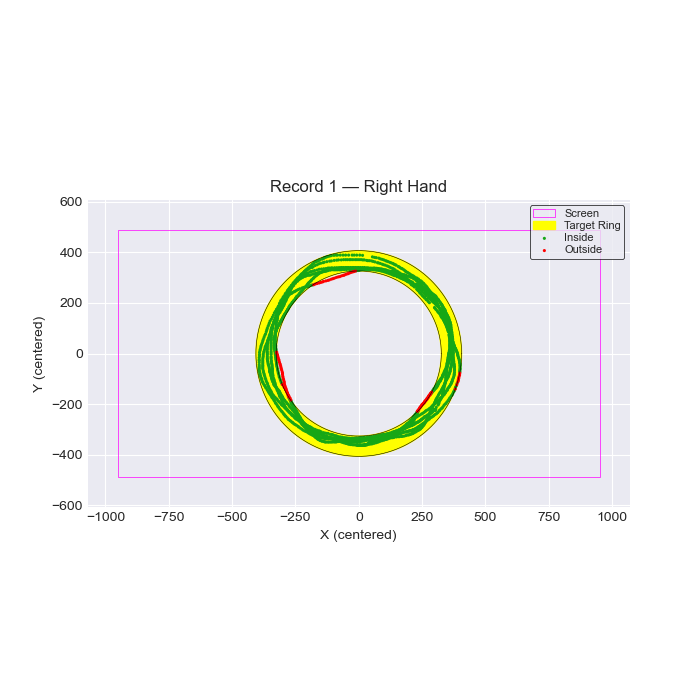

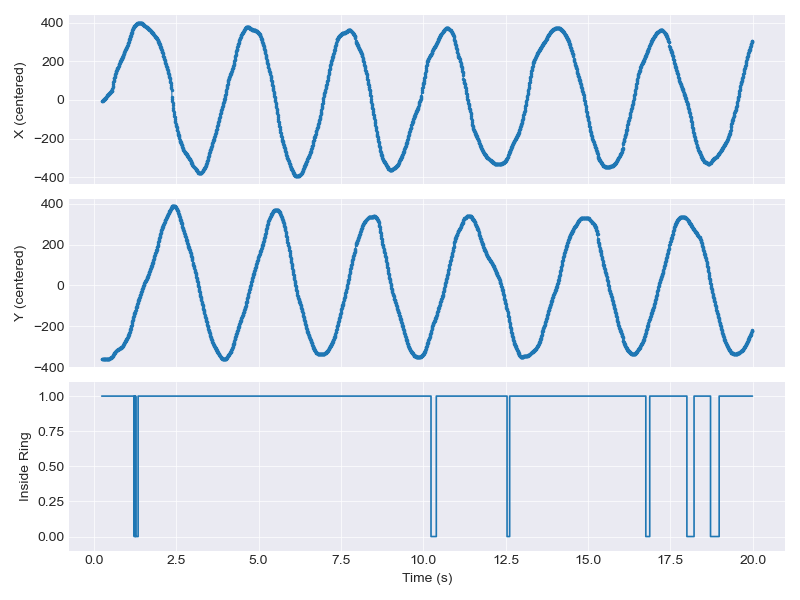


=== RECORD 2 ===


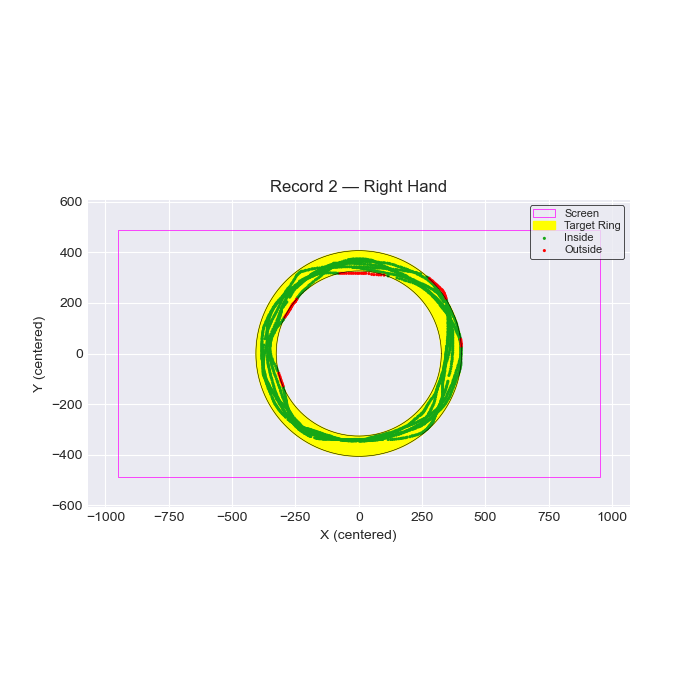

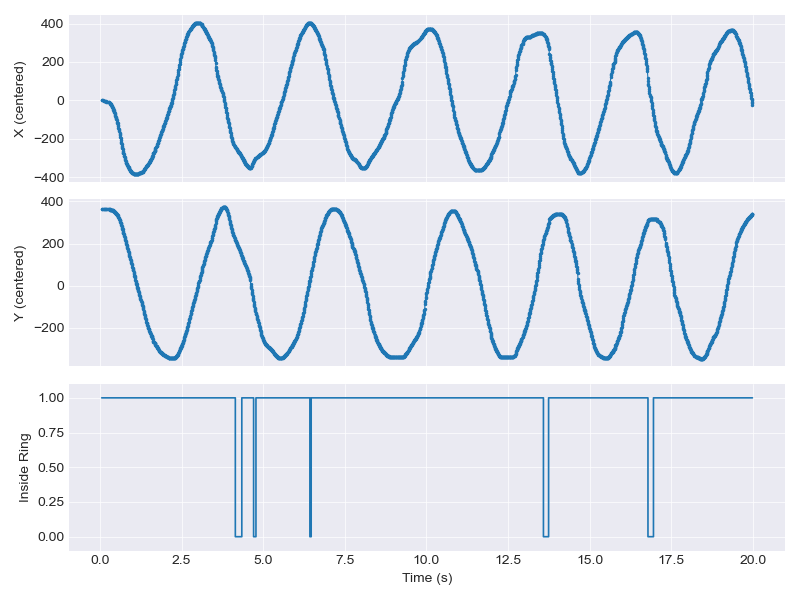


=== RECORD 3 ===


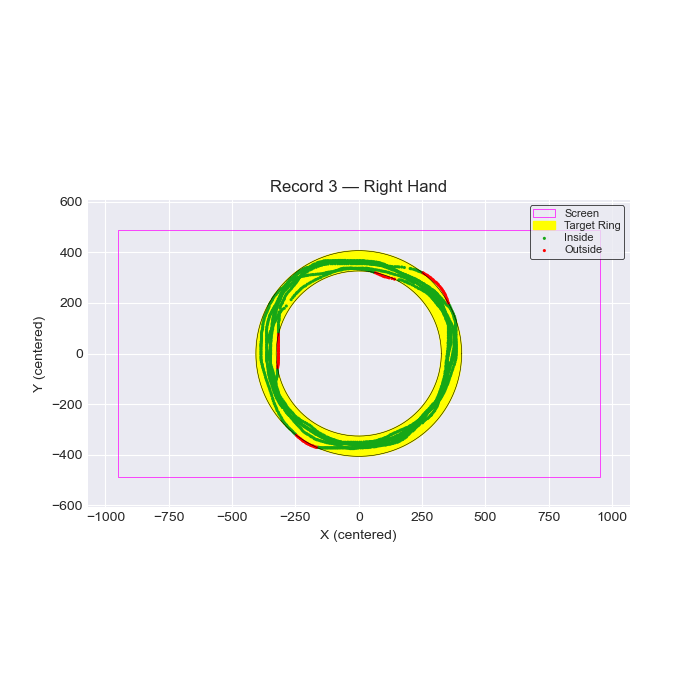

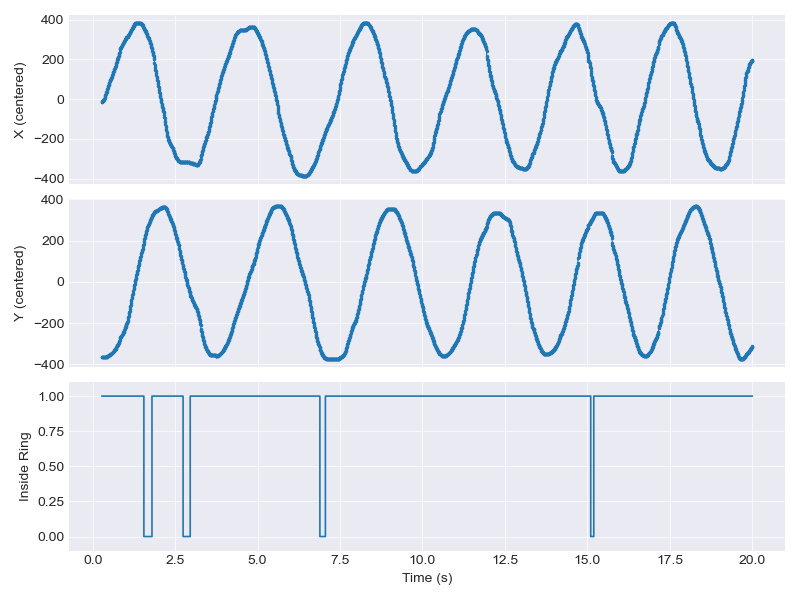


=== RECORD 4 ===


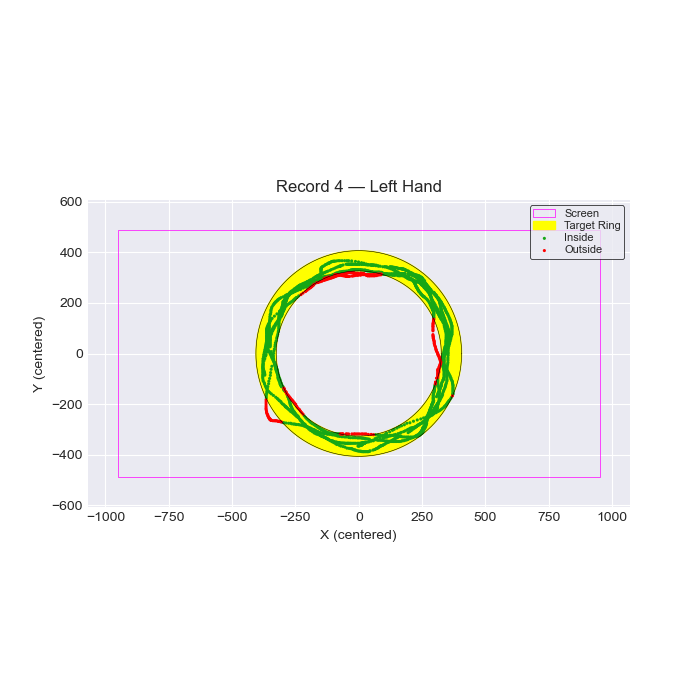

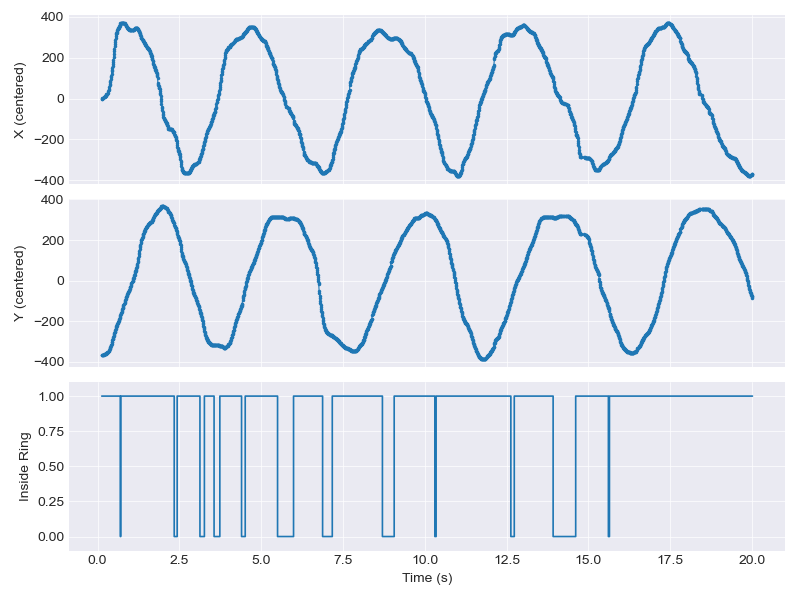


=== RECORD 5 ===


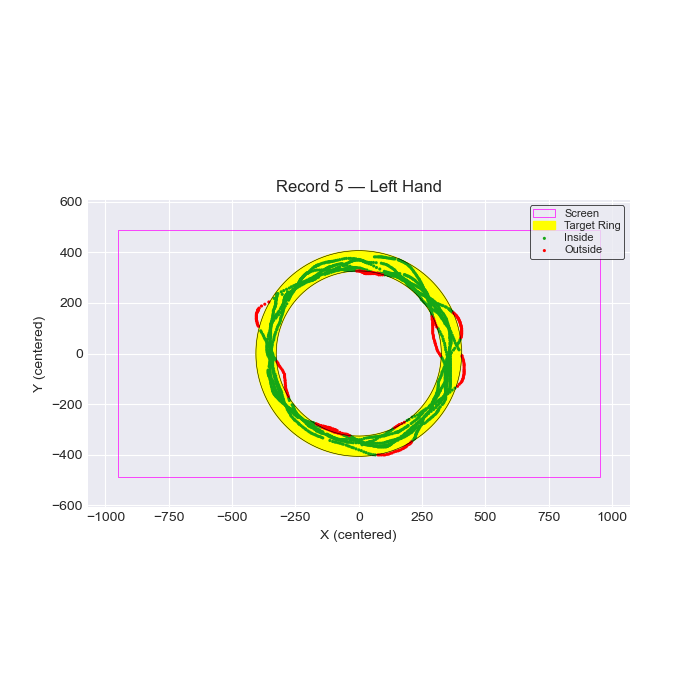

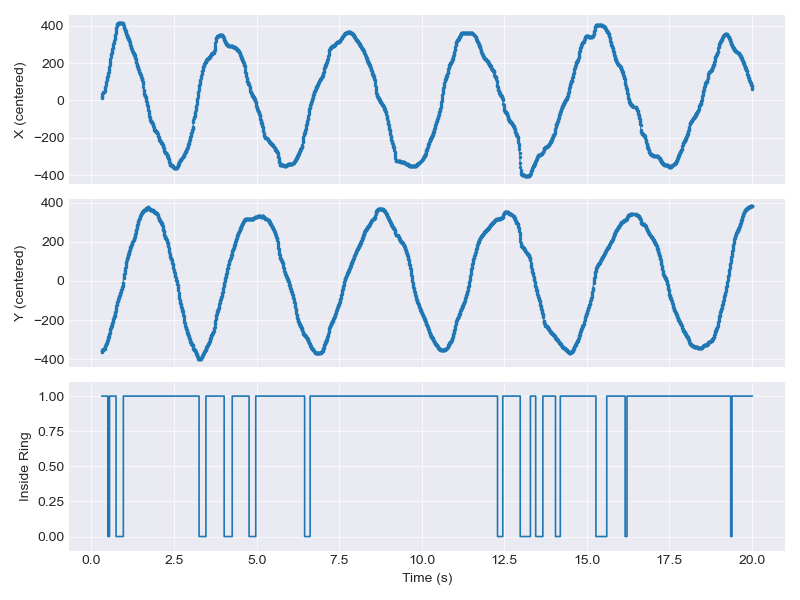


=== RECORD 6 ===


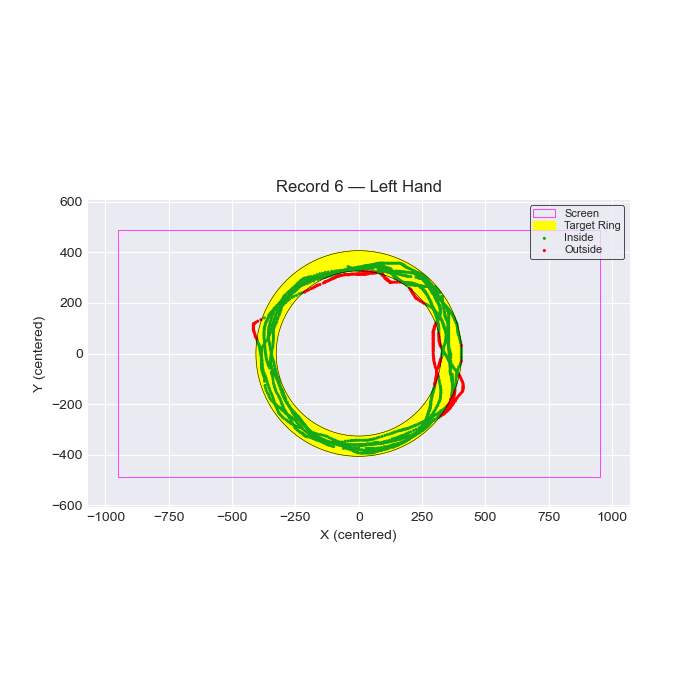

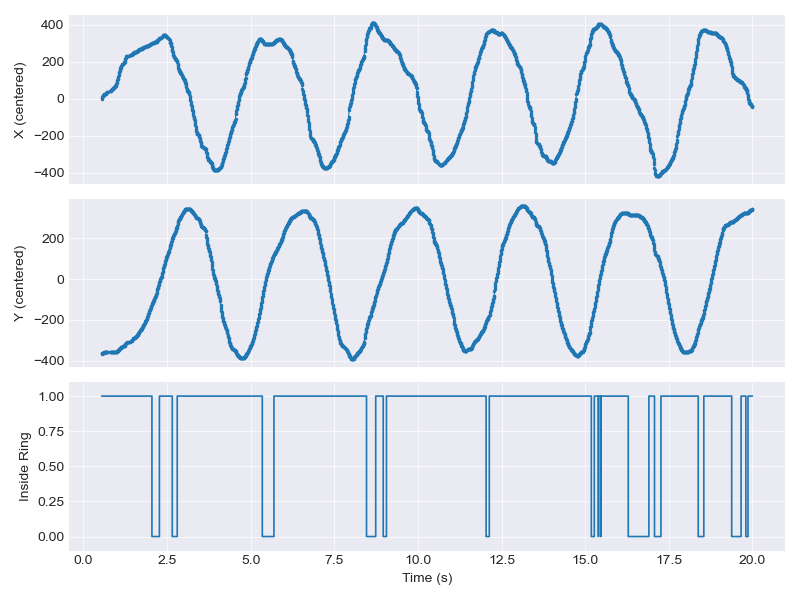

In [15]:
# =====================================================================
# README — How to use this section
# =====================================================================
# This section processes own generated mouse trajectory recordings from MouseReMoCo.
#
# TASK STRUCTURE:
#   • 6 cycles ("records")
#   • Each cycle lasts ~20 seconds ON, then ~20 seconds OFF
#   • Cycles 1–3  → Right Hand
#   • Cycles 4–6  → Left Hand
#   • Direction : Clockwise
#
# =====================================================================



# =====================================================================
# SECTION 1 — MARKER FILE  →  METADATA  →  CYCLE TIMES
# =====================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

print("=== LOADING MARKERS ===")

markers_raw = []

with open("data/record_1/001MoDe_R1.marker.csv", "r") as f:
    for line in f:
        L = line.strip()
        if not L:
            continue

        # Header (semicolon fields)
        if ";" in L and "," not in L:
            markers_raw.append(L.split(";"))
            continue

        # Timestamped events (comma-separated)
        if "," in L:
            markers_raw.append([p.strip() for p in L.split(",")])
            continue

        # Summary rows (space-separated)
        markers_raw.append(L.split())

print("Loaded", len(markers_raw), "marker rows")



# =====================================================================
# EXTRACT METADATA
# =====================================================================
header_line = markers_raw[0]
metadata = {}

for p in header_line:
    if "=" in p:
        k, v = p.split("=", 1)
        v = v.replace("java.awt.Color", "")
        metadata[k.strip()] = v.strip()

def auto(v):
    try:
        return float(v) if "." in v else int(v)
    except:
        return v

metadata_clean = {k: auto(v) for k, v in metadata.items()}

print("\n=== METADATA ===")
for k, v in metadata_clean.items():
    print(f"{k:20s} = {v}")



# =====================================================================
# EXTRACT CYCLE START/STOP
# =====================================================================
starts, stops = [], []

for row in markers_raw:
    if len(row) < 3:
        continue

    ts = row[1]
    event = row[2]

    if not ts.isdigit():
        continue

    t = int(ts)

    if "DoRecord" in event:
        starts.append(t)
    if "DoPause" in event:
        stops.append(t)

cycles = list(zip(starts, stops))

print("\n=== CYCLES DETECTED ===")
for i, (s, e) in enumerate(cycles):
    print(f"Cycle {i+1}: {s}  →  {e}   ({(e-s)/1000:.2f}s)")



# =====================================================================
# EXTRACT SCREEN + TASK PARAMETERS
# =====================================================================
screen_w = metadata_clean.get("screenWidth", 1902)
screen_h = metadata_clean.get("screenHeight", 973)
centerX  = metadata_clean.get("centerX", screen_w/2)
centerY  = metadata_clean.get("centerY", screen_h/2)

R_out  = metadata_clean.get("externalRadius", 406)
R_in   = metadata_clean.get("internalRadius", 326)
R_task = metadata_clean.get("taskRadius", 365.5)

print("\n=== TASK GEOMETRY ===")
print("Screen:", screen_w, "x", screen_h)
print("Center:", centerX, centerY)
print("Radii → Inner:", R_in, "Outer:", R_out, "Task:", R_task)



# =====================================================================
# SECTION 2 — LOAD MOUSE DATA
# =====================================================================
print("\n=== LOADING MOUSE DATA ===")

df = pd.read_csv("data/record_1/001MoDe_R1.csv", skiprows=4, header=None)
df = df.astype(float)
df.columns = ["timestamp", "x", "y", "inTarget"]

print("Mouse samples:", df.shape, "rows")

# Normalize timestamps
T0 = int(df["timestamp"].iloc[0])
df["t"] = (df["timestamp"] - T0) / 1000.0



# =====================================================================
# SECTION 3 — GEOMETRY (RINGS)
# =====================================================================
theta = np.linspace(0, 2*np.pi, 600)
x_outer = R_out * np.cos(theta)
y_outer = R_out * np.sin(theta)
x_inner = R_in  * np.cos(theta)
y_inner = R_in  * np.sin(theta)

xs_ring = np.concatenate([x_outer, x_inner[::-1]])
ys_ring = np.concatenate([y_outer, y_inner[::-1]])



# =====================================================================
# SECTION 4 — SPLIT DATASET INTO CYCLES
# =====================================================================
cycle_dfs = []
for (start, end) in cycles:
    d = df[(df.timestamp >= start) & (df.timestamp <= end)].copy()
    d["t_cycle"] = (d["timestamp"] - start) / 1000.0
    cycle_dfs.append(d)



# =====================================================================
# SECTION 5 — PLOT ALL SIX RECORDS
# =====================================================================
for i, d in enumerate(cycle_dfs):

    print(f"\n=== RECORD {i+1} ===")

    # Hand assignment
    hand = "Right Hand" if i < 3 else "Left Hand"

    # ----------------------------------------
    # CIRCULAR TRAJECTORY
    # ----------------------------------------
    fig = plt.figure(figsize=(7,7))
    ax = plt.gca()

    # SCREEN rectangle
    screen_rect = patches.Rectangle(
        (-centerX, -centerY),
        screen_w,
        screen_h,
        linewidth=0.5,
        edgecolor="magenta",
        facecolor="none",
        label="Screen")
    ax.add_patch(screen_rect)

    # Yellow ring
    ax.fill(xs_ring, ys_ring, color="#FFFF00", alpha=1.0, label="Target Ring")
    ax.plot(x_outer, y_outer, color="black", linewidth=0.4)
    ax.plot(x_inner, y_inner, color="black", linewidth=0.4)

    # Mouse trajectory
    x = d["x"].values - centerX
    y = d["y"].values - centerY
    r = np.hypot(x, y)
    inside = (r >= R_in) & (r <= R_out)

    ax.scatter(x[inside],  y[inside],  s=5, c="#16A716", edgecolors="none", label="Inside")
    ax.scatter(x[~inside], y[~inside], s=5, c="#FF0000", edgecolors="none", label="Outside")

    pad = 120
    ax.set_xlim(-centerX - pad, centerX + pad)
    ax.set_ylim(-centerY - pad, centerY + pad)
    ax.set_aspect("equal")

    plt.title(f"Record {i+1} — {hand}")
    plt.xlabel("X (centered)")
    plt.ylabel("Y (centered)")

    leg = ax.legend(loc="upper right", fontsize=8, frameon=True, fancybox=True,
                    borderpad=0.3, labelspacing=0.2)
    leg.get_frame().set_edgecolor("black")
    leg.get_frame().set_linewidth(0.6)

    plt.show()


    # ----------------------------------------
    # TIME SERIES
    # ----------------------------------------
    fig_ts, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 6))

    axs[0].plot(d["t_cycle"], x, marker='.', markersize=3, linewidth=0.8)
    axs[0].set_ylabel("X (centered)")
    axs[0].grid(True, linewidth=0.5)

    axs[1].plot(d["t_cycle"], y, marker='.', markersize=3, linewidth=0.8)
    axs[1].set_ylabel("Y (centered)")
    axs[1].grid(True, linewidth=0.5)

    axs[2].step(d["t_cycle"], inside.astype(int), where='mid', linewidth=1.2)
    axs[2].set_ylabel("Inside Ring")
    axs[2].set_ylim(-0.1, 1.1)
    axs[2].set_xlabel("Time (s)")
    axs[2].grid(True, linewidth=0.5)

    plt.tight_layout()
    plt.show()

<a id="4-title"></a>
# 4. [Discussion, limitations, and conclusions](#total-title)

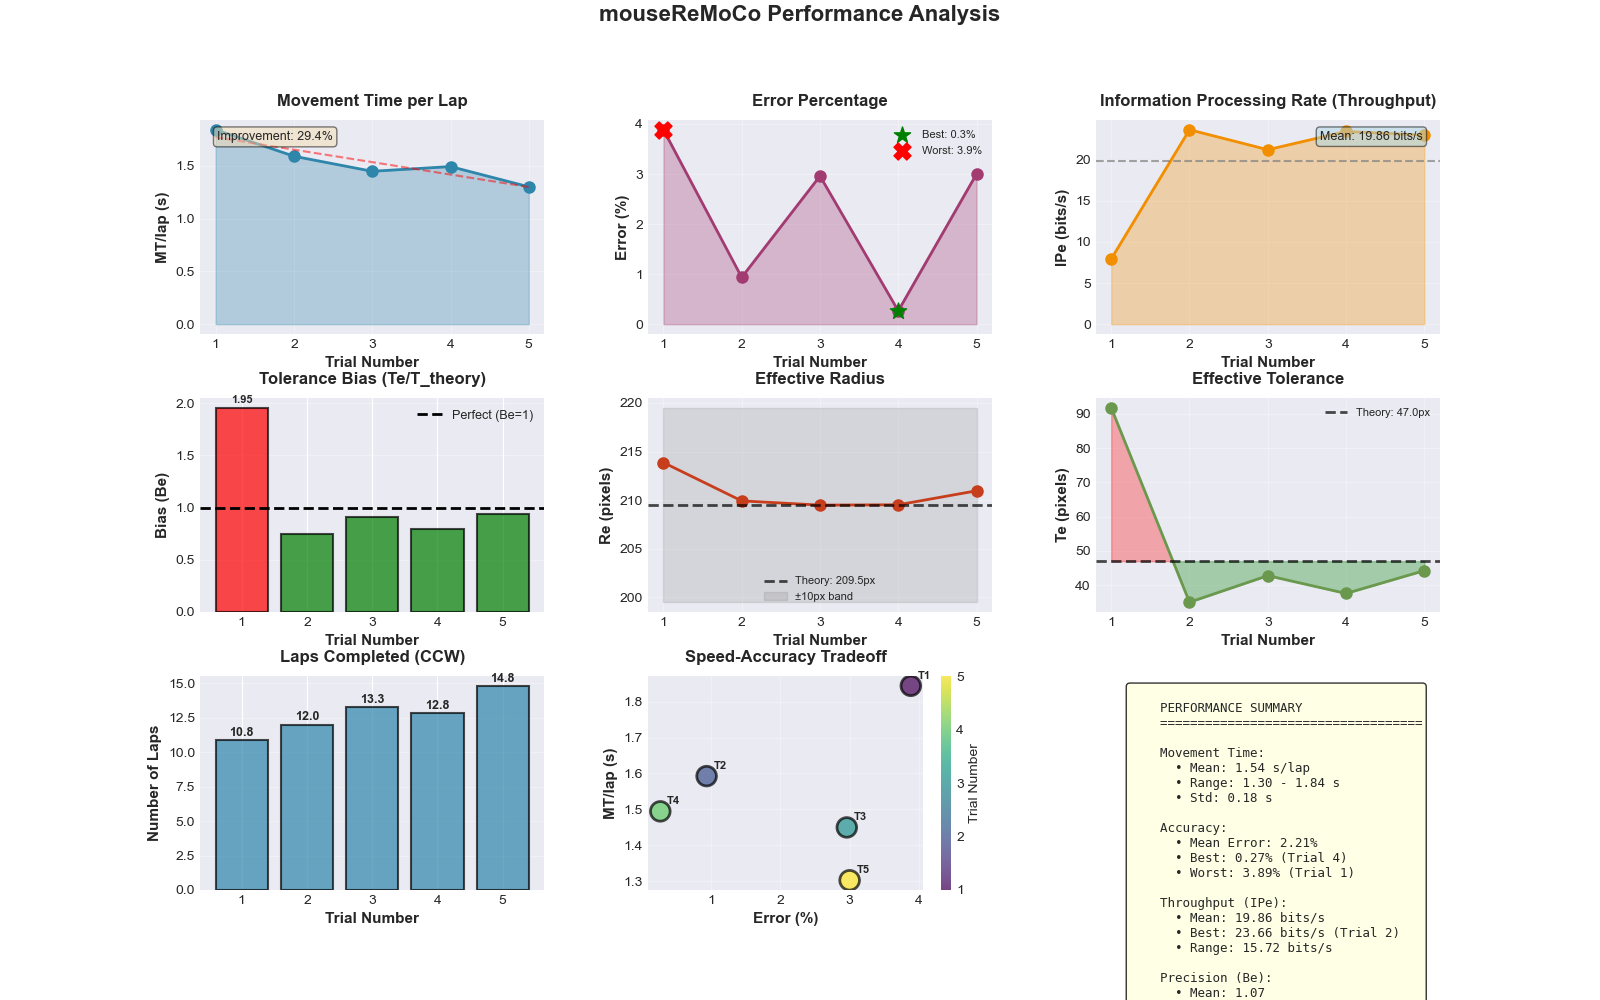

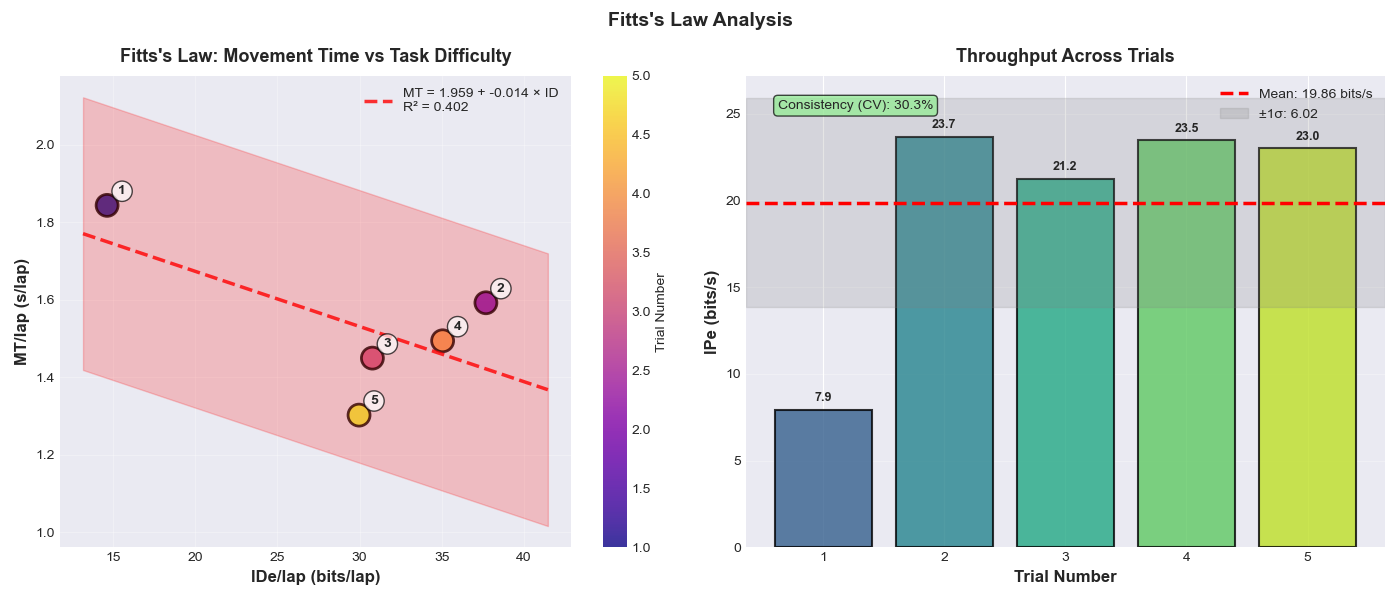

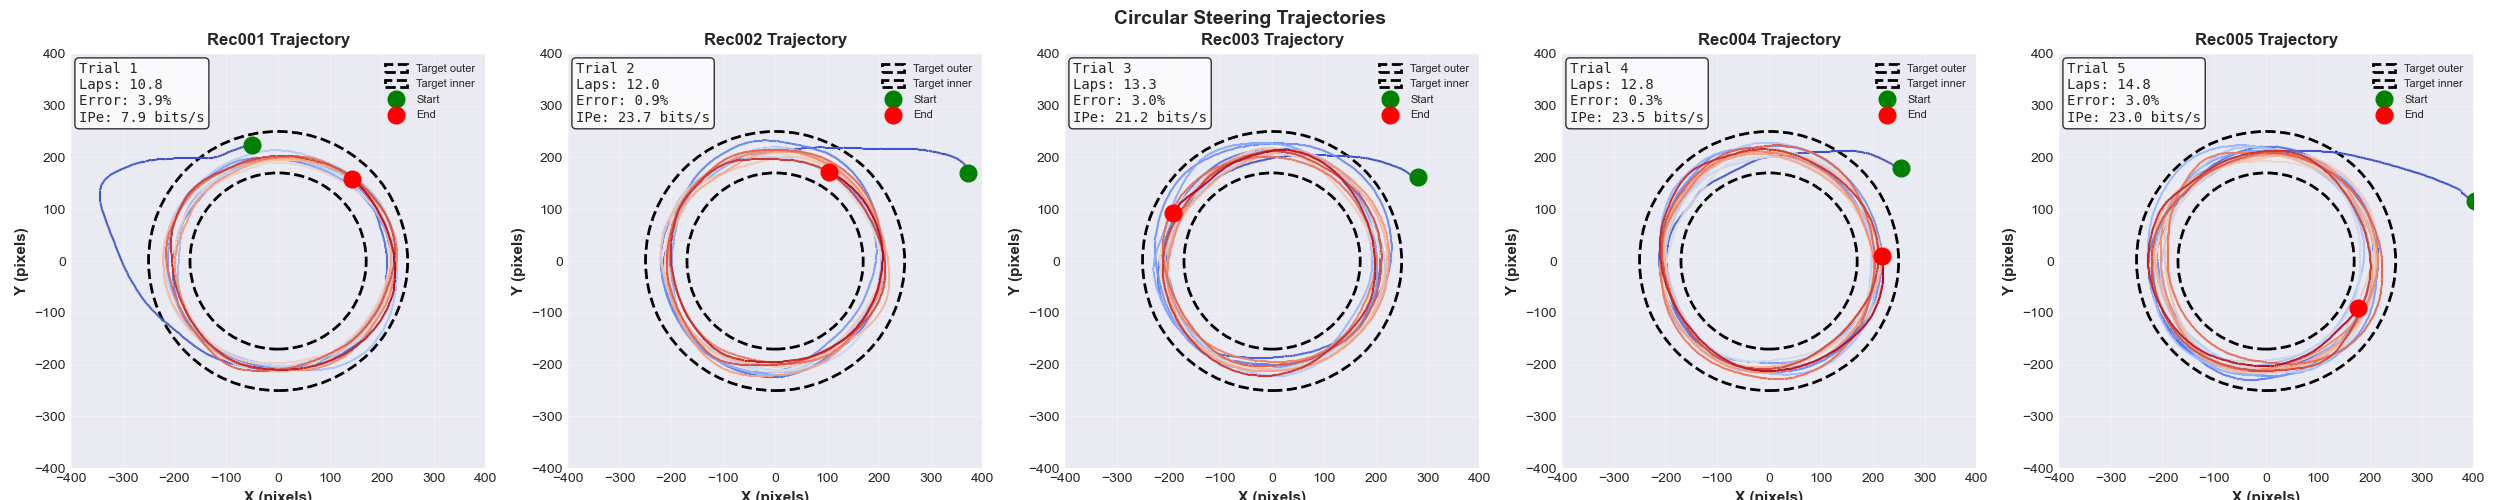


✅ All visualizations saved!
  • performance_analysis.png
  • fitts_law_analysis.png
  • trajectories.png


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge
import matplotlib.patches as mpatches
from scipy import stats

# ----------------------
# Enhanced Visualization (Run after computing results)
# ----------------------

if len(results) > 0:
    # Set style for better appearance
    plt.style.use('seaborn-v0_8-darkgrid')
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E']
    
    # ========================
    # Figure 1: Performance Metrics Over Trials
    # ========================
    fig1 = plt.figure(figsize=(16, 10))
    gs = fig1.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    trial_nums = np.array(range(1, len(results) + 1))
    
    # --- Movement Time per Lap ---
    ax1 = fig1.add_subplot(gs[0, 0])
    mt_vals = [r['MT/lap'] for r in results]
    ax1.plot(trial_nums, mt_vals, 'o-', color=colors[0], linewidth=2, markersize=8)
    ax1.fill_between(trial_nums, mt_vals, alpha=0.3, color=colors[0])
    ax1.set_xlabel('Trial Number', fontsize=11, fontweight='bold')
    ax1.set_ylabel('MT/lap (s)', fontsize=11, fontweight='bold')
    ax1.set_title('Movement Time per Lap', fontsize=12, fontweight='bold', pad=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(trial_nums)
    
    # Add trend line
    if len(trial_nums) > 1:
        z = np.polyfit(trial_nums, mt_vals, 1)
        p = np.poly1d(z)
        ax1.plot(trial_nums, p(trial_nums), '--', alpha=0.5, color='red', linewidth=1.5)
        improvement = ((mt_vals[0] - mt_vals[-1]) / mt_vals[0]) * 100
        ax1.text(0.05, 0.95, f'Improvement: {improvement:.1f}%', 
                transform=ax1.transAxes, fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # --- Error Percentage ---
    ax2 = fig1.add_subplot(gs[0, 1])
    error_vals = [r['error'] for r in results]
    ax2.plot(trial_nums, error_vals, 'o-', color=colors[1], linewidth=2, markersize=8)
    ax2.fill_between(trial_nums, error_vals, alpha=0.3, color=colors[1])
    ax2.set_xlabel('Trial Number', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Error (%)', fontsize=11, fontweight='bold')
    ax2.set_title('Error Percentage', fontsize=12, fontweight='bold', pad=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(trial_nums)
    
    # Highlight best and worst
    best_idx = np.argmin(error_vals)
    worst_idx = np.argmax(error_vals)
    ax2.scatter([trial_nums[best_idx]], [error_vals[best_idx]], 
               s=150, color='green', marker='*', zorder=5, label=f'Best: {error_vals[best_idx]:.1f}%')
    if best_idx != worst_idx:
        ax2.scatter([trial_nums[worst_idx]], [error_vals[worst_idx]], 
                   s=150, color='red', marker='X', zorder=5, label=f'Worst: {error_vals[worst_idx]:.1f}%')
    ax2.legend(loc='upper right', fontsize=8)
    
    # --- Information Processing Rate (IPe) ---
    ax3 = fig1.add_subplot(gs[0, 2])
    ipe_vals = [r['IPe'] for r in results]
    ax3.plot(trial_nums, ipe_vals, 'o-', color=colors[2], linewidth=2, markersize=8)
    ax3.fill_between(trial_nums, ipe_vals, alpha=0.3, color=colors[2])
    ax3.set_xlabel('Trial Number', fontsize=11, fontweight='bold')
    ax3.set_ylabel('IPe (bits/s)', fontsize=11, fontweight='bold')
    ax3.set_title('Information Processing Rate (Throughput)', fontsize=12, fontweight='bold', pad=10)
    ax3.grid(True, alpha=0.3)
    ax3.set_xticks(trial_nums)
    
    # Add mean line
    mean_ipe = np.mean(ipe_vals)
    ax3.axhline(y=mean_ipe, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
    ax3.text(0.95, 0.95, f'Mean: {mean_ipe:.2f} bits/s', 
            transform=ax3.transAxes, fontsize=9, verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    
    # --- Tolerance Bias (Be) ---
    ax4 = fig1.add_subplot(gs[1, 0])
    be_vals = [r['Be'] for r in results]
    colors_be = ['green' if b < 1 else 'orange' if b < 1.5 else 'red' for b in be_vals]
    bars = ax4.bar(trial_nums, be_vals, color=colors_be, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax4.axhline(y=1.0, color='black', linestyle='--', linewidth=2, label='Perfect (Be=1)')
    ax4.set_xlabel('Trial Number', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Bias (Be)', fontsize=11, fontweight='bold')
    ax4.set_title('Tolerance Bias (Te/T_theory)', fontsize=12, fontweight='bold', pad=10)
    ax4.grid(True, alpha=0.3, axis='y')
    ax4.set_xticks(trial_nums)
    ax4.legend(loc='upper right', fontsize=9)
    
    # Add annotations
    for i, (t, b) in enumerate(zip(trial_nums, be_vals)):
        if b > 1.5 or b < 0.7:
            ax4.text(t, b + 0.05, f'{b:.2f}', ha='center', fontsize=8, fontweight='bold')
    
    # --- Effective Radius (Re) ---
    ax5 = fig1.add_subplot(gs[1, 1])
    re_vals = [r['Re'] for r in results]
    ax5.plot(trial_nums, re_vals, 'o-', color=colors[3], linewidth=2, markersize=8)
    ax5.axhline(y=R_theory, color='black', linestyle='--', linewidth=2, alpha=0.7, label=f'Theory: {R_theory:.1f}px')
    ax5.fill_between(trial_nums, R_theory - 10, R_theory + 10, alpha=0.2, color='gray', label='±10px band')
    ax5.set_xlabel('Trial Number', fontsize=11, fontweight='bold')
    ax5.set_ylabel('Re (pixels)', fontsize=11, fontweight='bold')
    ax5.set_title('Effective Radius', fontsize=12, fontweight='bold', pad=10)
    ax5.grid(True, alpha=0.3)
    ax5.set_xticks(trial_nums)
    ax5.legend(loc='best', fontsize=8)
    
    # --- Effective Tolerance (Te) ---
    ax6 = fig1.add_subplot(gs[1, 2])
    te_vals = [r['Te'] for r in results]
    ax6.plot(trial_nums, te_vals, 'o-', color=colors[4], linewidth=2, markersize=8)
    ax6.axhline(y=T_theory, color='black', linestyle='--', linewidth=2, alpha=0.7, label=f'Theory: {T_theory:.1f}px')
    ax6.fill_between(trial_nums, te_vals, T_theory, alpha=0.3, 
                     where=np.array(te_vals) >= T_theory, color='red', interpolate=True)
    ax6.fill_between(trial_nums, te_vals, T_theory, alpha=0.3, 
                     where=np.array(te_vals) < T_theory, color='green', interpolate=True)
    ax6.set_xlabel('Trial Number', fontsize=11, fontweight='bold')
    ax6.set_ylabel('Te (pixels)', fontsize=11, fontweight='bold')
    ax6.set_title('Effective Tolerance', fontsize=12, fontweight='bold', pad=10)
    ax6.grid(True, alpha=0.3)
    ax6.set_xticks(trial_nums)
    ax6.legend(loc='best', fontsize=8)
    
    # --- Number of Laps ---
    ax7 = fig1.add_subplot(gs[2, 0])
    nlaps_vals = [abs(r['nLaps']) for r in results]
    direction = ['CCW' if r['nLaps'] < 0 else 'CW' for r in results]
    bars = ax7.bar(trial_nums, nlaps_vals, color=colors[0], alpha=0.7, edgecolor='black', linewidth=1.5)
    ax7.set_xlabel('Trial Number', fontsize=11, fontweight='bold')
    ax7.set_ylabel('Number of Laps', fontsize=11, fontweight='bold')
    ax7.set_title(f'Laps Completed ({direction[0]})', fontsize=12, fontweight='bold', pad=10)
    ax7.grid(True, alpha=0.3, axis='y')
    ax7.set_xticks(trial_nums)
    
    # Add lap count on bars
    for i, (t, n) in enumerate(zip(trial_nums, nlaps_vals)):
        ax7.text(t, n + 0.3, f'{n:.1f}', ha='center', fontsize=9, fontweight='bold')
    
    # --- Speed-Accuracy Tradeoff ---
    ax8 = fig1.add_subplot(gs[2, 1])
    scatter = ax8.scatter(error_vals, mt_vals, c=trial_nums, cmap='viridis', 
                         s=200, alpha=0.7, edgecolors='black', linewidth=2)
    ax8.set_xlabel('Error (%)', fontsize=11, fontweight='bold')
    ax8.set_ylabel('MT/lap (s)', fontsize=11, fontweight='bold')
    ax8.set_title('Speed-Accuracy Tradeoff', fontsize=12, fontweight='bold', pad=10)
    ax8.grid(True, alpha=0.3)
    
    # Add trial labels
    for i, (e, m) in enumerate(zip(error_vals, mt_vals)):
        ax8.annotate(f'T{i+1}', (e, m), xytext=(5, 5), textcoords='offset points', 
                    fontsize=8, fontweight='bold')
    
    cbar = plt.colorbar(scatter, ax=ax8)
    cbar.set_label('Trial Number', fontsize=10)
    
    # --- Summary Statistics ---
    ax9 = fig1.add_subplot(gs[2, 2])
    ax9.axis('off')
    
    summary_text = f"""
    PERFORMANCE SUMMARY
    {'='*35}
    
    Movement Time:
      • Mean: {np.mean(mt_vals):.2f} s/lap
      • Range: {np.min(mt_vals):.2f} - {np.max(mt_vals):.2f} s
      • Std: {np.std(mt_vals):.2f} s
    
    Accuracy:
      • Mean Error: {np.mean(error_vals):.2f}%
      • Best: {np.min(error_vals):.2f}% (Trial {np.argmin(error_vals)+1})
      • Worst: {np.max(error_vals):.2f}% (Trial {np.argmax(error_vals)+1})
    
    Throughput (IPe):
      • Mean: {np.mean(ipe_vals):.2f} bits/s
      • Best: {np.max(ipe_vals):.2f} bits/s (Trial {np.argmax(ipe_vals)+1})
      • Range: {np.max(ipe_vals) - np.min(ipe_vals):.2f} bits/s
    
    Precision (Be):
      • Mean: {np.mean(be_vals):.2f}
      • Trials within ±20%: {sum(0.8 <= b <= 1.2 for b in be_vals)}/{len(be_vals)}
    """
    
    ax9.text(0.1, 0.95, summary_text, transform=ax9.transAxes, fontsize=9,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    plt.suptitle('mouseReMoCo Performance Analysis', fontsize=16, fontweight='bold', y=0.995)
#   plt.savefig('performance_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # ========================
    # Figure 2: Fitts's Law Analysis
    # ========================
    fig2, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    ide_vals = [r['IDe/lap'] for r in results]
    mt_vals = [r['MT/lap'] for r in results]
    
    # --- Classic Fitts's Law Plot ---
    ax = axes[0]
    scatter = ax.scatter(ide_vals, mt_vals, c=trial_nums, cmap='plasma', 
                        s=250, alpha=0.8, edgecolors='black', linewidth=2)
    
    # Linear regression
    if len(ide_vals) > 1:
        slope, intercept, r_value, p_value, std_err = stats.linregress(ide_vals, mt_vals)
        x_fit = np.linspace(min(ide_vals)*0.9, max(ide_vals)*1.1, 100)
        y_fit = slope * x_fit + intercept
        ax.plot(x_fit, y_fit, 'r--', linewidth=2.5, alpha=0.8,
               label=f'MT = {intercept:.3f} + {slope:.3f} × ID\nR² = {r_value**2:.3f}')
        
        # 95% confidence interval
        predict_std = np.sqrt(np.sum((mt_vals - (slope * np.array(ide_vals) + intercept))**2) / (len(mt_vals) - 2))
        margin = 1.96 * predict_std
        ax.fill_between(x_fit, y_fit - margin, y_fit + margin, alpha=0.2, color='red')
    
    # Add trial labels
    for i, (ide, mt) in enumerate(zip(ide_vals, mt_vals)):
        ax.annotate(f'{i+1}', (ide, mt), xytext=(8, 8), textcoords='offset points',
                   fontsize=10, fontweight='bold', 
                   bbox=dict(boxstyle='circle', facecolor='white', alpha=0.7))
    
    ax.set_xlabel('IDe/lap (bits/lap)', fontsize=12, fontweight='bold')
    ax.set_ylabel('MT/lap (s/lap)', fontsize=12, fontweight='bold')
    ax.set_title("Fitts's Law: Movement Time vs Task Difficulty", fontsize=13, fontweight='bold', pad=10)
    ax.legend(loc='best', fontsize=10, framealpha=0.9)
    ax.grid(True, alpha=0.3)
    
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Trial Number', fontsize=10)
    
    # --- Throughput Consistency ---
    ax2 = axes[1]
    ipe_vals = [r['IPe'] for r in results]
    
    # Bar plot with color gradient
    colors_grad = plt.cm.viridis(np.linspace(0.3, 0.9, len(trial_nums)))
    bars = ax2.bar(trial_nums, ipe_vals, color=colors_grad, alpha=0.8, 
                   edgecolor='black', linewidth=1.5)
    
    # Add mean line
    mean_ipe = np.mean(ipe_vals)
    ax2.axhline(y=mean_ipe, color='red', linestyle='--', linewidth=2.5, 
               label=f'Mean: {mean_ipe:.2f} bits/s')
    
    # Add ±1 std band
    std_ipe = np.std(ipe_vals)
    ax2.axhspan(mean_ipe - std_ipe, mean_ipe + std_ipe, alpha=0.2, color='gray',
               label=f'±1σ: {std_ipe:.2f}')
    
    # Add values on top of bars
    for i, (t, ipe) in enumerate(zip(trial_nums, ipe_vals)):
        ax2.text(t, ipe + 0.5, f'{ipe:.1f}', ha='center', fontsize=9, fontweight='bold')
    
    ax2.set_xlabel('Trial Number', fontsize=12, fontweight='bold')
    ax2.set_ylabel('IPe (bits/s)', fontsize=12, fontweight='bold')
    ax2.set_title('Throughput Across Trials', fontsize=13, fontweight='bold', pad=10)
    ax2.legend(loc='best', fontsize=10, framealpha=0.9)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_xticks(trial_nums)
    
    # Calculate coefficient of variation
    cv = (std_ipe / mean_ipe) * 100
    ax2.text(0.05, 0.95, f'Consistency (CV): {cv:.1f}%', 
            transform=ax2.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
    
    plt.suptitle("Fitts's Law Analysis", fontsize=14, fontweight='bold')
    plt.tight_layout()
#   plt.savefig('fitts_law_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # ========================
    # Figure 3: Trajectory Visualization
    # ========================
    fig3, axes = plt.subplots(1, len(data_groups), figsize=(5*len(data_groups), 5))
    if len(data_groups) == 1:
        axes = [axes]
    
    for idx, g in enumerate(data_groups):
        ax = axes[idx]
        
        # Draw target annulus
        circle_outer = Circle((0, 0), EXTERNAL_LIMIT, fill=False, 
                             edgecolor='black', linewidth=2, linestyle='--', label='Target outer')
        circle_inner = Circle((0, 0), INTERNAL_LIMIT, fill=False, 
                             edgecolor='black', linewidth=2, linestyle='--', label='Target inner')
        ax.add_patch(circle_outer)
        ax.add_patch(circle_inner)
        
        # Plot trajectory with color map based on time
        x, y = g['x'], g['y']
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        from matplotlib.collections import LineCollection
        lc = LineCollection(segments, cmap='coolwarm', linewidth=1.5)
        lc.set_array(np.linspace(0, 1, len(x)))
        ax.add_collection(lc)
        
        # Mark start and end
        ax.plot(x[0], y[0], 'go', markersize=12, label='Start', zorder=5)
        ax.plot(x[-1], y[-1], 'ro', markersize=12, label='End', zorder=5)
        
        # Add metrics text
        if idx < len(results) and results[idx] is not None:
            r = results[idx]
            text = (f"Trial {idx+1}\n"
                   f"Laps: {abs(r['nLaps']):.1f}\n"
                   f"Error: {r['error']:.1f}%\n"
                   f"IPe: {r['IPe']:.1f} bits/s")
            ax.text(0.02, 0.98, text, transform=ax.transAxes, fontsize=10,
                   verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        ax.set_xlim(-400, 400)
        ax.set_ylim(-400, 400)
        ax.set_aspect('equal')
        ax.set_xlabel('X (pixels)', fontsize=11, fontweight='bold')
        ax.set_ylabel('Y (pixels)', fontsize=11, fontweight='bold')
        ax.set_title(f'Rec{idx+1:03d} Trajectory', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper right', fontsize=8)
    
    plt.suptitle('Circular Steering Trajectories', fontsize=14, fontweight='bold')
    plt.tight_layout()
#   plt.savefig('trajectories.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✅ All visualizations saved!")
    print("  • performance_analysis.png")
    print("  • fitts_law_analysis.png")
    print("  • trajectories.png")

In [17]:
# https://nbconvert.readthedocs.io/en/latest/removing_cells.html

# https://github.com/msm1089/ipynbname/issues/17#issuecomment-1293269863


from traitlets.config import Config
from nbconvert.exporters import HTMLExporter
from nbconvert.preprocessors import TagRemovePreprocessor
from IPython import get_ipython


def get_notebook_name():
    """
    Get the current notebook name (without extension).
    """
    ip = get_ipython()
    path = None
    if "__vsc_ipynb_file__" in ip.user_ns:
        path = ip.user_ns["__vsc_ipynb_file__"]

    return path.split("/")[-1].split(".")[0]


# Get the notebook name
notebook_file_name = get_notebook_name()


# Setup config
c = Config()

# Configure tag removal - be sure to tag your cells to remove  using the
# words remove_cell to remove cells. You can also modify the code to use
# a different tag word
c.TagRemovePreprocessor.remove_cell_tags = ("remove",)
c.TagRemovePreprocessor.remove_all_outputs_tags = ("remove_output",)
c.TagRemovePreprocessor.remove_input_tags = ("hide",)
c.TagRemovePreprocessor.enabled = True
c.HTMLExporter.preprocessors = ["nbconvert.preprocessors.TagRemovePreprocessor"]

# ensure the graphics are included in the html
c.HTMLExporter.embed_images = True
# do not show the input code cells (distracts from the output)
c.HTMLExporter.exclude_output_prompt = True
c.HTMLExporter.exclude_input_prompt = True

# Configure the exporter
exporter = HTMLExporter(config=c)
exporter.register_preprocessor(TagRemovePreprocessor(config=c), True)


# run our exporter - returns a tuple - first element with html,
# second with notebook metadata
output = HTMLExporter(config=c).from_filename(notebook_file_name + ".ipynb")

# Write to output html file
with open(notebook_file_name + ".html", "w") as f:
    f.write(output[0])

# open the file with the operating system
import os

# if osx use open, if linux use xdg-open, if windows use start
try:
    if os.name == "posix":
        if os.uname().sysname == "Darwin":
            # macOS
            errorCode = os.system("open " + notebook_file_name + ".html")
        else:
            # Linux
            errorCode = os.system("xdg-open " + notebook_file_name + ".html")
    elif os.name == "nt":
        # Windows
        errorCode = os.system("start " + notebook_file_name + ".html")
    else:
        print("Unsupported OS")
except Exception as e:
    print("Error opening file: ", e)